

### I uploaded files on my google drive, you'll need to do the same file dump if you want to try it (sorry, will fix later)
-Eric

In [7]:
import cv2
import numpy as np
import glob
from google.colab import drive
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.metrics import MeanAbsoluteError
import matplotlib.pyplot as plt

# Gaussian Blur, honestly not sure how it influences performance
def apply_gaussian_blur(image):
    blurred_image = cv2.GaussianBlur(image, (9, 9), 2)
    return blurred_image

# Function to crop the image
def crop_image(image):
    height, width, _ = image.shape
    cropped_image = image[int(height * 0.1):int(height * 0.90), int(width * 0.3):int(width * 0.7), :]
    return cropped_image

# Function to calculate gradient magnitude
def calculate_gradient_magnitude(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=5)
    gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)
    gradient_magnitude = cv2.normalize(gradient_magnitude, None, 0, 255, cv2.NORM_MINMAX)
    return gradient_magnitude

# Function to load, resize, and apply gradient magnitude processing
def load_and_process_image(file_path, new_size=(64, 64)):
    image = cv2.imread(file_path)
    blurred_image = apply_gaussian_blur(image)
    cropped_image = crop_image(blurred_image)
    processed_image = calculate_gradient_magnitude(cropped_image)
    resized_image = cv2.resize(processed_image, new_size, interpolation=cv2.INTER_AREA)
    return np.expand_dims(resized_image, axis=-1)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 48851.9883 - val_loss: 73318.7344
Epoch 2/200
1/1 [==============================] - 0s 171ms/step - loss: 46633.5898 - val_loss: 64825.9062
Epoch 3/200
1/1 [==============================] - 0s 159ms/step - loss: 43467.5000 - val_loss: 56427.5430
Epoch 4/200
1/1 [==============================] - 0s 157ms/step - loss: 40033.3203 - val_loss: 47687.7969
Epoch 5/200
1/1 [==============================] - 0s 168ms/step - loss: 37325.5625 - val_loss: 39423.9297
Epoch 6/200
1/1 [==============================] - 0s 168ms/step - loss: 31647.4824 - val_loss: 31812.7109
Epoch 7/200
1/1 [==============================] - 0s 157ms/step - loss: 27257.6348 - val_loss: 25425.1270
Epoch 8/200
1/1 [==============================] - 0s 155ms/step - loss: 23840.5801 - val_loss: 20176.6719
Epoch 9/200
1/1 [=

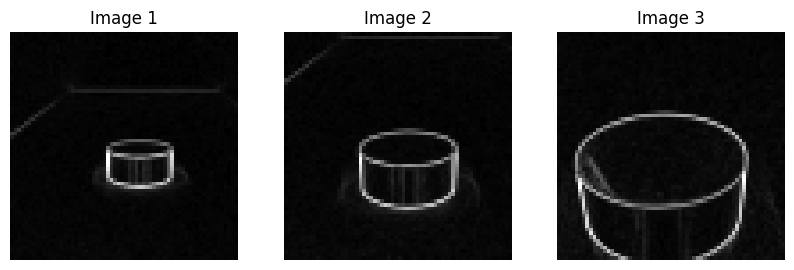

In [13]:

drive.mount('/content/drive')

directory_path = '/content/drive/My Drive/CV_proj/'
file_paths = glob.glob(directory_path + '*.jpg')
images = []
volumes = []

volume_mapping = {
    '1.jpg': 392.70, '2.jpg': 392.70, '3.jpg': 392.70,
    '4.jpg': 98.17, '5.jpg': 98.17, '6.jpg': 98.17,
    '7.jpg': 12.27, '8.jpg': 12.27, '9.jpg': 12.27
}

for file_path in file_paths:
    processed_image = load_and_process_image(file_path)
    images.append(processed_image)
    file_name = file_path.split('/')[-1]
    volume = volume_mapping.get(file_name)
    if volume is not None:
        volumes.append(volume)

# Check step
if len(images) != len(volumes):
    raise ValueError("The number of images does not match the number of volumes.")

X = np.array(images).astype('float32')
y = np.array(volumes).astype('float32')

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Data augmentation generator -- very useful lol
augmenter = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=5,
    zoom_range=0.1
)

# Model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=9999) #Setting patience super high, don't care for early stopping much
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True) # I don't actually use saved model

model.fit(augmenter.flow(X_train, y_train, batch_size=32),
          validation_data=(X_val, y_val),
          epochs=200,
          callbacks=[early_stopping, model_checkpoint])
y_pred = model.predict(X_val).flatten()

# Function to calculate custom accuracy, open to feedback
def calculate_accuracy(y_true, y_pred, tolerance=10):
    accurate_predictions = np.abs(y_true - y_pred) <= tolerance
    accuracy = np.mean(accurate_predictions)
    return accuracy

custom_accuracy = calculate_accuracy(y_val, y_pred)
print(f"Custom Accuracy (within ±10 units): {custom_accuracy * 100:.2f}%")

#MAE
mae = MeanAbsoluteError()
mae.update_state(y_val, y_pred)
print(f"Mean Absolute Error: {mae.result().numpy():.2f}")

def display_images(images, num_images=3):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i].reshape(64, 64), cmap='gray')
        plt.title(f"Image {i+1}")
        plt.axis("off")
    plt.show()

# Load and display a few processed images
sample_images = [load_and_process_image(file_paths[i]) for i in range(3)]
display_images(sample_images)


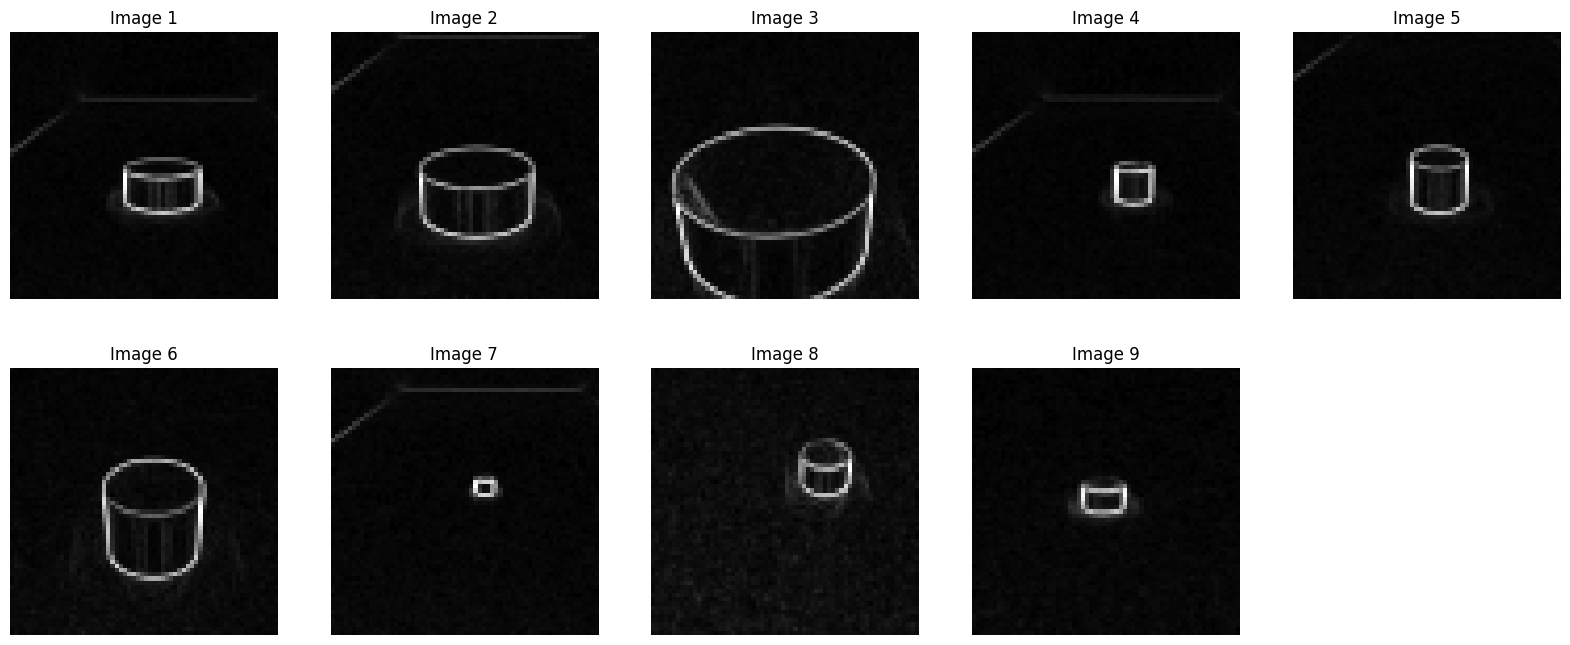

In [9]:
def display_processed_images(images, cols=5):
    # Determine the number of rows required
    rows = len(images) // cols + 1

    plt.figure(figsize=(20, 4 * rows))
    for i, image in enumerate(images):
        ax = plt.subplot(rows, cols, i + 1)
        plt.imshow(image.reshape(64, 64), cmap='gray')
        plt.title(f"Image {i+1}")
        plt.axis("off")
    plt.show()

display_processed_images(images)


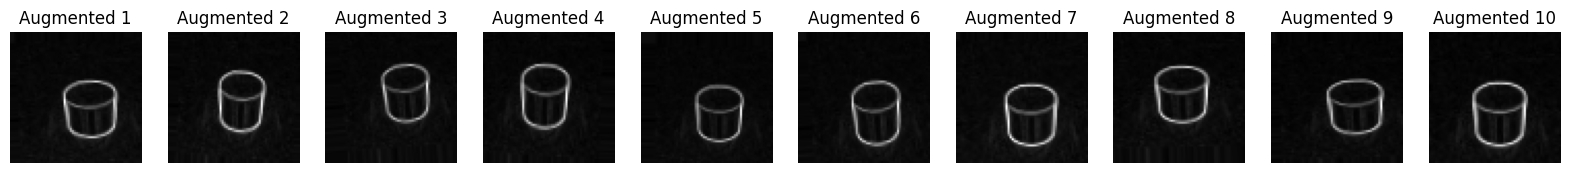

In [10]:
def display_augmented_images(image_generator, original_image, num_images=10):
    image_generator.fit(np.array([original_image]))

    plt.figure(figsize=(20, 4))
    for i in range(num_images):
        # Generate augmented image
        augmented_image = next(image_generator.flow(np.array([original_image]), batch_size=1))

        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(augmented_image[0].reshape(64, 64), cmap='gray')
        plt.title(f"Augmented {i+1}")
        plt.axis("off")
    plt.show()

# Select an original image to augment
original_image = X_train[0]  # This is user chosen, just make sure it's in range btw

display_augmented_images(augmenter, original_image)


1/1 [==============================] - 0s 38ms/step


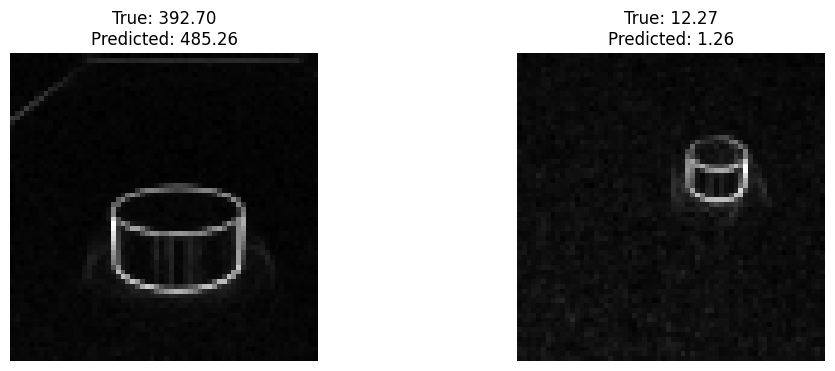

In [11]:
import random
import matplotlib.pyplot as plt

def display_predictions(images, true_volumes, predicted_volumes, num_images=3):
    num_samples = min(num_images, len(images))  # dont sample more images than available
    indices = random.sample(range(len(images)), num_samples)

    plt.figure(figsize=(12, 4))
    for i, index in enumerate(indices):
        ax = plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[index].reshape(64, 64), cmap='gray')
        plt.title(f"True: {true_volumes[index]:.2f}\nPredicted: {predicted_volumes[index]:.2f}")
        plt.axis("off")
    plt.show()

predicted_volumes = model.predict(X_val).flatten()

display_predictions(X_val, y_val, predicted_volumes)


In [12]:
# This is a WIP -- I don't think it works at the moment -E

def calculate_custom_accuracy(y_true, y_pred, volumes):
    unique_volumes = list(set(volumes))
    print(unique_volumes)
    if len(unique_volumes) != 3:
        raise ValueError("The number of unique volumes must be exactly 3.")

    correct_predictions = 0
    for true_val, pred_val in zip(y_true, y_pred):
        differences = [abs(pred_val - vol) for vol in unique_volumes]

        closest_volume_index = differences.index(min(differences))

        # check if the closest volume is the actual volume
        if unique_volumes[closest_volume_index] == true_val:
            correct_predictions += 1

    return correct_predictions / len(y_true)

unique_volume_values = [392.70, 98.17, 12.27]

custom_accuracy = calculate_custom_accuracy(y_val, predicted_volumes, unique_volume_values)
print(f"Custom Accuracy: {custom_accuracy * 100:.2f}%")


[392.7, 98.17, 12.27]
Custom Accuracy: 0.00%
